In [1]:
from joblib import Parallel, delayed
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Polygon
from matplotlib import colors

plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True

In [2]:
import sys
if 'lib' not in sys.path:
    sys.path.append('lib')





In [3]:
from compare_QPSK import *

#### Verifying the indexing of the constellation:

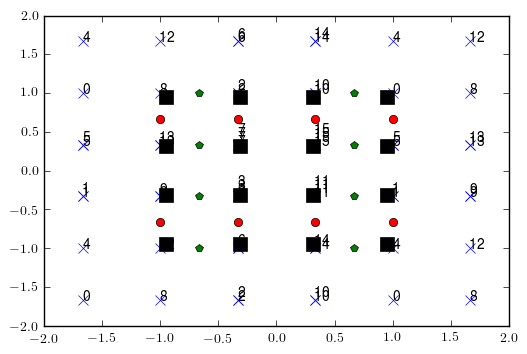

In [15]:
## BitXOR
Nb = 2
Ns = 1
(sourceA_const, sourceB_const, basic_part, relay_const, alpha) = const_design_XOR(Nb, Ns)
ind_const = np.asarray([s1* 2**(Nb + Ns) + s2 * 2**(Nb) + (b1^b2) \
              for s1 in range(0, 2**Ns) for b1 in range(0, 2**Nb) \
              for s2 in range(0, 2**Ns) for b2 in range(0, 2**Nb)] )
plt.plot(np.real(sourceA_const), np.imag(sourceA_const),'ro')
plt.plot(np.real(sourceB_const), np.imag(sourceB_const),'gp')
plt.plot(np.real(relay_const), np.imag(relay_const),'x',ms=7)
vec = np.unique(np.round(relay_const,10))
cnt = np.zeros(len(vec))
for i in range(0,len(relay_const)):
    arg = np.nonzero(np.abs(vec - relay_const[i]) < 1e-8)
    shift = cnt[arg]
    act_string = str(ind_const[i])
#    act_string = "".join((str(i), str(dec2bin(i,((Nb+Ns)*2))), str(ind_const[i])))
    plt.text(np.real(relay_const[i]), np.imag(relay_const[i]) + 0.05 * shift, act_string)
    cnt[arg] += 1 
#plt.legend(['Source A', 'Source B', 'Relay'])
for i in QAM(4)[0]:
    plt.plot(np.real(i), np.imag(i),'ks', ms=10)
plt.show()

In [2]:
## ModSum
Nb = 4
Ns = 4
(sourceA_const, sourceB_const, basic_part, relay_const,alpha) = const_design_MS(Nb, Ns)
ind_const = np.asarray([s1* 2**(Nb + Ns) + s2 * 2**(Nb) + (np.mod(b1+b2, 2**Nb)) \
              for s1 in range(0, 2**Ns) for b1 in range(0, 2**Nb) \
              for s2 in range(0, 2**Ns) for b2 in range(0, 2**Nb)] )
plt.plot(np.real(relay_const), np.imag(relay_const),'x')
vec = np.unique(np.round(relay_const,10))
cnt = np.zeros(len(vec))
for i in range(0,len(relay_const)):
    arg = np.nonzero(np.abs(vec - relay_const[i]) < 1e-8)
    shift = cnt[arg]
    act_string = str(ind_const[i])
    #act_string = "".join((str(i), str(dec2bin(i,((Nb+Ns)*2))), str(ind_const[i])))
    plt.text(np.real(relay_const[i]), np.imag(relay_const[i]) + 0.005 * shift, act_string)
    cnt[arg] += 1 
plt.show()

In [5]:
plt.plot(np.real(sourceA_const), np.imag(sourceA_const),'x')
for i in range(0,len(sourceA_const)):    
    act_string = "".join((str(i), str(dec2bin(i,Nb+Ns))))
    plt.text(np.real(sourceA_const[-1-i]), np.imag(sourceA_const[-1-i]) + 0.05, act_string)
plt.show()

#### Drawing Minimal distance:

In [15]:
## bit-wise XOR
N = 2
dist = np.asarray([[min_dist_eval(i, N-i, phi, mapping = 'XOR') \
       for phi in np.arange(0,np.pi*2,np.pi/5)] for i in range(0,N+1)])
for i in range(0, N+1):
    plt.plot(dist[i,:])
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

In [3]:
## Mod-Sum
N = 2
dist = np.asarray([[min_dist_eval(i, N-i, phi, mapping = 'MS') \
       for phi in np.arange(0,np.pi*2,np.pi/5)] for i in range(0,N+1)])
for i in range(0, N+1):
    plt.plot(dist[i,:])
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

#### Overall throughput Evaluation:

In [15]:
SNR_HSI = np.arange(0,30,0.1)
SNR_MAC = np.arange(0,30,0.1)
len_frame = 768
N = 4 # Number of maximum bits per symbol in BC stage

tupples = np.asarray([(i,j) for i in range(0, N+1) for j in range(0, N-i+1) if i+2*j<=N])[1:] # all feassible Nb,Ns tupples
through = []
#through = [np.zeros([len(SNR_MAC), len(SNR_HSI)])] * (tupples.shape[0])
for [Nb, Ns] in tupples:
    through.append(Throughput_Eval_range(Nb, Ns, N, SNR_MAC, SNR_HSI, mapping='XOR', len_frame=len_frame))    

In [16]:
## Draw particular overall throughput + regions of dominance

max_through = np.asarray(through).max(axis=0)
map_max = (through == max_through)
levs_total = np.arange(0,N+0.1,0.2)
#CS1 = plt.contour(max_through,len(levs),\
#      levels=levs_total, colors='y',\
#      extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
#zc = CS1.collections[0:len(levs_total):5] #
#plt.setp(zc, linewidth=4)
#plt.xlabel('SNR MAC [dB]')
#plt.ylabel('SNR HSI [dB]')
#plt.clabel(CS1, levs[0::2], inline=1, fmt='%1.1f', fontsize=14)

plt.imshow(max_through[-1::-1,:],\
extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)]) # xmin, xmax, ymin, ymax
plt.colorbar()
plt.xlabel('SNR MAC [dB]')
plt.ylabel('SNR HSI [dB]')


for i in range(0, len(through)):
    act_max = through[i]
    act_range = np.hstack([np.arange(0, i), np.arange(i+1, len(through))])
    other_max = np.max(np.asarray(np.asarray(through)[act_range,:,:]),axis=0)
    levs = [0]
    CS = plt.contour(act_max-other_max,len(levs),\
                levels=levs, colors='k',\
                extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
    zc = CS.collections[0] # Stronger isolines
    plt.setp(zc, linewidth=4)

    
    # Text description of regions
    Nb = tupples[i, 0]
    Ns = tupples[i, 1]
    s = "".join(('(',str(Nb),',',str(Ns),')'))
    line = np.arange(np.min(SNR_MAC), np.max(SNR_MAC),(SNR_MAC[-1]-SNR_MAC[0])/float(len(SNR_MAC)))
    act_advantage = np.zeros(np.shape(max_through))
    act_region = np.nonzero(max_through-other_max > 0)
    act_advantage[act_region] = max_through[act_region]-other_max[act_region]

    x = np.nonzero(act_advantage == np.max(act_advantage))[1][0]
    y = np.nonzero(act_advantage == np.max(act_advantage))[0][0]
    plt.text(line[x],line[y],s)

plt.title('Throughput and strategy regions for XOR mapping')    
plt.savefig('XOR_map.pdf')
    
plt.show()

In [17]:
## Draw throughput advantage of dominant region + regions of dominance 
plt.figure()
max_through = np.asarray(through).max(axis=0)
map_max = (through == max_through)
region_advantage = np.zeros(np.shape(max_through))

for i in range(0, len(through)):
    act_max = through[i]
    act_range = np.hstack([np.arange(0, i), np.arange(i+1, len(through))])
    other_max = np.max(np.asarray(np.asarray(through)[act_range,:,:]),axis=0) 
    act_region = np.nonzero(max_through-other_max > 0)
    region_advantage[act_region] = max_through[act_region]-other_max[act_region]

    levs = [0]
#    plt.contour(act_max - other_max)
    CS = plt.contour(act_max-other_max,len(levs),\
                levels=levs, colors='k',\
                extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
    zc = CS.collections[0] # Stronger isolines
    plt.setp(zc, linewidth=4)    

plt.imshow(region_advantage[-1::-1,:],extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
plt.xlabel('SNR MAC [dB]')
plt.ylabel('SNR HSI [dB]')
plt.title('Throughput advantage of the dominant strategy')
plt.colorbar()
plt.savefig('XOR_map_advantage.pdf')
plt.show()


In [5]:
## Draw particular overall throughput + regions of dominance

max_through = np.asarray(through).max(axis=0)
map_max = (through == max_through)
levs_total = np.arange(0,N+0.1,0.2)
region_advantage = np.zeros(np.shape(max_through))
#CS1 = plt.contour(max_through,len(levs),\
#      levels=levs_total, colors='y',\
#      extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
#zc = CS1.collections[0:len(levs_total):5] #
#plt.setp(zc, linewidth=4)
#plt.xlabel('SNR MAC [dB]')
#plt.ylabel('SNR HSI [dB]')
#plt.clabel(CS1, levs[0::2], inline=1, fmt='%1.1f', fontsize=14)

plt.imshow(max_through[-1::-1,:],\
extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)]) # xmin, xmax, ymin, ymax
plt.colorbar()
plt.xlabel('SNR MAC [dB]')
plt.ylabel('SNR HSI [dB]')


for i in range(0, len(through)):
    act_max = through[i]
    act_range = np.hstack([np.arange(0, i), np.arange(i+1, len(through))])
    other_max = np.max(np.asarray(np.asarray(through)[act_range,:,:]),axis=0)
    levs = [0]
    CS = plt.contour(act_max-other_max,len(levs),\
                levels=levs, colors='k',\
                extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
    zc = CS.collections[0] # Stronger isolines
    plt.setp(zc, linewidth=4)
    
    act_region = np.nonzero(max_through-other_max > 0)
    region_advantage[act_region] = max_through[act_region]-other_max[act_region]

    
    # Text description of regions
    Nb = tupples[i, 0]
    Ns = tupples[i, 1]
    s = "".join(('(',str(Nb),',',str(Ns),')'))
    line = np.arange(np.min(SNR_MAC), np.max(SNR_MAC),(SNR_MAC[-1]-SNR_MAC[0])/len(SNR_MAC))
    act_advantage = np.zeros(np.shape(max_through))
    act_region = np.nonzero(max_through-other_max > 0)
    act_advantage[act_region] = max_through[act_region]-other_max[act_region]

    x = np.nonzero(act_advantage == np.max(act_advantage))[1][0]
    y = np.nonzero(act_advantage == np.max(act_advantage))[0][0]
    plt.text(line[x],line[y],s)
    

#levs = np.arange(0.1,1,0.4)
#CS = plt.contour(region_advantage,len(levs),\
#                levels=levs, colors='m',\
#                extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)]) 
#zc = CS.collections # Stronger isolines
#plt.setp(zc, linewidth=0.5)  
#plt.clabel(CS, levs, inline=1, fmt='%1.1f', fontsize=10)
plt.title('Throughput and strategy regions for Mod Sum')
plt.savefig('../results/MS_basic.svg')
plt.show()

In [13]:
## Draw particular overall throughput + regions of dominance

max_through = np.asarray(through).max(axis=0)
map_max = (through == max_through)
levs_total = np.arange(0,N+0.1,0.2)
region_advantage = np.zeros(np.shape(max_through))
#CS1 = plt.contour(max_through,len(levs),\
#      levels=levs_total, colors='y',\
#      extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
#zc = CS1.collections[0:len(levs_total):5] #
#plt.setp(zc, linewidth=4)
#plt.xlabel('SNR MAC [dB]')
#plt.ylabel('SNR HSI [dB]')
#plt.clabel(CS1, levs[0::2], inline=1, fmt='%1.1f', fontsize=14)


plt.xlabel('SNR MAC [dB]')
plt.ylabel('SNR HSI [dB]')


for i in range(0, len(through)):
    act_max = through[i]
    act_range = np.hstack([np.arange(0, i), np.arange(i+1, len(through))])
    other_max = np.max(np.asarray(np.asarray(through)[act_range,:,:]),axis=0)
    levs = [0]
    CS = plt.contour(act_max-other_max,len(levs),\
                levels=levs, colors='k',\
                extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
    zc = CS.collections[0] # Stronger isolines
    plt.setp(zc, linewidth=4)
    
    # Text description of regions
    Nb = tupples[i, 0]
    Ns = tupples[i, 1]
    s = "".join(('(',str(Nb),',',str(Ns),')'))
    line = np.arange(np.min(SNR_MAC), np.max(SNR_MAC),(SNR_MAC[-1]-SNR_MAC[0])/len(SNR_MAC))
    act_advantage = np.zeros(np.shape(max_through))
    act_region = np.nonzero(max_through-other_max > 0)
    act_advantage[act_region] = max_through[act_region]-other_max[act_region]

    x = np.nonzero(act_advantage == np.max(act_advantage))[1][0]
    y = np.nonzero(act_advantage == np.max(act_advantage))[0][0]
    if (x > 0) or (y>0):
        plt.text(line[x],line[y],s)    
   
plt.title('Strategy region map for Mod Sum mapping')
plt.savefig('../results/MS_map.pdf')
plt.show()

In [18]:
def Through_e(Nb,Ns):
  print 'processing ', Nb, Ns
  t = 0  
  phi_axis = np.arange(0,2*np.pi,np.pi/60.)
  for phi in phi_axis:
    h_act = np.exp(1j * phi)
#    print phi, h_act
    t += Throughput_Eval_range_all(Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, 'XOR',len_frame, h_act, D='single')
  return t/float(len(phi_axis))

SNR_HSI = np.arange(0,30,0.1)
SNR_MAC = np.arange(2,29,0.1)
#SNR_BC = np.arange(15,21,1)
SNR_BC = np.array([15,17,20,25])
len_frame = 768
N = 4 # Number of maximum bits per symbol in BC stage
    
tupples = np.asarray([(i,j) for i in range(0, N+1) for j in range(0, N-i+1) if i+2*j<=N])[1:] # all feassible Nb,Ns tupples
through = []
avg = 0 # Averaging
par = 1 # Parralel evaluation
#through = [np.zeros([len(SNR_MAC), len(SNR_HSI)])] * (tupples.shape[0])
if avg == 0:
  if par == 0:
    for [Nb, Ns] in tupples:
      through.append(Throughput_Eval_range_all(Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, 'XOR',len_frame, h=1., D='single'))
  else:
    through = Parallel(n_jobs=8)(delayed(Throughput_Eval_range_all)\
        (Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, 'XOR', len_frame, h=1., D='single') for (Nb, Ns) in tupples)

elif avg == 1: # Uniform averaging 
  if par == 0:
    for [Nb, Ns] in tupples:  
      through.append(Through_e(Nb,Ns))
  else:
    through = Parallel(n_jobs=8)(delayed(Through_e)(Nb, Ns) for (Nb, Ns) in tupples)
#    through.append(Throughput_Eval_range_all(Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, 'XOR',len_frame, h=1., D='single'))


strategy = np.zeros([len(SNR_MAC), len(SNR_HSI), len(SNR_BC)],int)
for i in range(len(through)):
  act_range = np.hstack([np.arange(0, i), np.arange(i+1, len(through))])  
#  print np.asarray(through)[act_range,:,:]
  z,y,x = np.nonzero(through[i]>(np.max(np.asarray(through)[act_range,:,:,:], axis=0)))
  for j in range(len(x)):
    strategy[x[j], y[j],z[j]] = i
#print strategy
#print tupples

for i in range(len(SNR_BC)):
#  plt.figure(figsize=(15, 15))
#  plt.figure(figsize=(8, 8))
  plt.figure()    
  max_through = np.asarray(through)[:,i,:,:].max(axis=0)
  map_max = (through == max_through)
  levs_total = np.arange(0,N+0.1,0.2)
 

  ax = plt.gca()
  im = ax.imshow(2*max_through[-1::-1,:],\
  extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)],vmin=0, vmax=4) # xmin, xmax, ymin, ymax               
#  extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)]) # xmin, xmax, ymin, ymax  
  
  plt.xlabel('$\gamma_{MAC}$ [dB]', fontsize=16)
  plt.ylabel('$\gamma_{HSI}$ [dB]', fontsize=16)
  plt.title('$\gamma_{BC}$='+str(SNR_BC[i])+' dB', fontsize=16)  
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.2)

  plt.colorbar(im, cax=cax)
#  plt.colorbar()
#  plt.title('Throughput for $\gamma_{BC}$='+str(SNR_BC[i])+'dB')


    
  for j in range(0, len(through)):
    act_max = through[j][i,:,:]
    act_range = np.hstack([np.arange(0, j), np.arange(j+1, len(through))])
    other_max = np.max(np.asarray(np.asarray(through)[act_range,i,:,:]),axis=0)
    levs = [0]
    CS = ax.contour(act_max-other_max,len(levs),\
                levels=levs, colors='k',\
                extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
    zc = CS.collections[0] # Stronger isolines
    plt.setp(zc, linewidth=4)

    
    # Text description of regions
    Nb = tupples[j, 0]
    Ns = tupples[j, 1]
    s = "".join(('(',str(Nb),',',str(Ns),')'))
    lineX = np.arange(np.min(SNR_MAC), np.max(SNR_MAC),(SNR_MAC[-1]-SNR_MAC[0])/float(len(SNR_MAC)))
    lineY = np.arange(np.min(SNR_HSI), np.max(SNR_HSI),(SNR_HSI[-1]-SNR_HSI[0])/float(len(SNR_HSI)))    
    act_advantage = np.zeros(np.shape(max_through))
    act_region = np.nonzero(max_through-other_max > 0)
    act_advantage[act_region] = max_through[act_region]-other_max[act_region]

    x = np.nonzero(act_advantage == np.max(act_advantage))[1][0]
    y = np.nonzero(act_advantage == np.max(act_advantage))[0][0]
    if ((x != 0) or (y != 0)):
      ax.text(lineX[x]-2,lineY[y]+0.5,s,  bbox=dict(facecolor='white', edgecolor='black', pad=5.0))
  
  plt.xticks(np.arange(2,30,3))
  plt.yticks(np.arange(0,31,3))  
  ax.grid(None)
  plt.savefig('../XOR_map_Througput_BC'+str(SNR_BC[i])+'.eps',bbox_inches='tight')
plt.show()

/usr/lib64/python2.7/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


In [19]:
SNR_HSI = np.linspace(0,25,26)
SNR_MAC = np.linspace(0,25,26)
#SNR_BC = np.arange(15,21,1)
SNR_BC = np.array([7.5, 15])
len_frame = 768
N = 4 # Number of maximum bits per symbol in BC stage
    
tupples = np.asarray([(i,j) for i in range(0, N+1) for j in range(0, N-i+1) if i+2*j<=N])[1:] # all feassible Nb,Ns tupples
through = []

par = 1 # Parralel evaluation
#through = [np.zeros([len(SNR_MAC), len(SNR_HSI)])] * (tupples.shape[0])

if par == 0:
  for [Nb, Ns] in tupples:
    through.append(Throughput_Eval_range_all(Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, 'XOR',len_frame, h=1., D='single'))
else:
  through = Parallel(n_jobs=8)(delayed(Throughput_Eval_range_all)\
      (Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, 'XOR', len_frame, h=1., D='single') for (Nb, Ns) in tupples)



for i in range(len(SNR_BC)):
#  plt.figure(figsize=(15, 15))
#  plt.figure(figsize=(8, 8))
  plt.figure()    
  max_through = np.asarray(through)[:,i,:,:].max(axis=0)
  map_max = (through == max_through)
  levs_total = np.arange(0,N+0.1,0.2)
 

  ax = plt.gca()
  im = ax.imshow(aa[i][-1::-1,:]-(2*max_through[-1::-1,:]),\
  extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)],vmin=0.75, vmax=2) # xmin, xmax, ymin, ymax                                
  #extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)],vmin=0, vmax=4) # xmin, xmax, ymin, ymax                   


  
  plt.xlabel('$\gamma_{MAC}$ [dB]', fontsize=16)
  plt.ylabel('$\gamma_{HSI}$ [dB]', fontsize=16)
  plt.title('$\gamma_{BC}$='+str(SNR_BC[i])+' dB', fontsize=16)  
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.2)

  plt.colorbar(im, cax=cax)
#  plt.colorbar()
#  plt.title('Throughput for $\gamma_{BC}$='+str(SNR_BC[i])+'dB')


  
  plt.xticks(np.arange(0,30,3))
  plt.yticks(np.arange(0,30,3))  
  ax.grid(None)
  plt.savefig('../XOR_map_Througput_coding_Gain'+str(SNR_BC[i])+'.eps',bbox_inches='tight')
plt.show()

NameError: name 'aa' is not defined

In [34]:
np.max(aa[i][-1::-1,:]-(2*max_through[-1::-1,:]))

1.9583646846161389

#### Demodulation Mapping:

In [ ]:
Nb = 3
Ns = 3
N = 100
dA=np.random.randint(2**(Nb+Ns),size=N) # Random data
dB=np.random.randint(2**(Nb+Ns),size=N)

dAb = dA % (2**Nb) # Separation to basic and superposed part
dBb = dB % (2**Nb)
dAs = dA / (2**Nb)
dBs = dB / (2**Nb)

# Indexing the relay constelation
ind_const = np.asarray([s1* 2**(Nb + Ns) + s2 * 2**(Nb) + (b1^b2) \
              for s1 in range(0, 2**Ns) for b1 in range(0, 2**Nb) \
              for s2 in range(0, 2**Ns) for b2 in range(0, 2**Nb)] )

dR = dAs * 2**(Nb + Ns) + dBs * 2**(Nb) + (dAb^dBb) # The relay data

(sourceA_const, sourceB_const, basic_part, relay_const, alpha) = const_design_XOR(Nb, Ns)
in0 = sourceA_const[dA] + sourceB_const[dB]

dist = np.asarray([np.abs(in0 - s0)**2 for s0 in relay_const] ) # Minimum distance based decision
out = ind_const[np.argmin(dist, axis = 0)] 
#print dA, dB, dAb, dAs, dBb, dBs

len((np.nonzero(out != dR)[0]))

0

#### Evaluation of Throughput with Dependece on HSI for fixed MAC and BC

In [28]:
def eval_LB(SNR_MAC, SNR_BC):
    SNR_HSI = np.linspace(0,20,21)

    frame_len = 768.
    num_frames = 10000
    h = 1.
    D = 'single' # Evaluation errors only in one destination
    #D = 'both' # Evaluation errors in both destinations
    mapping = 'XOR'
    par = 1 # Parallel evaluation
    pairs = [(0,2),(1,1),(2,0)]
    if par == 1:
        l = Parallel(n_jobs=8)(delayed(Throughput_Eval_range_all)(Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, mapping, frame_len, h ,D) for (Nb,Ns) in pairs)
        line = [x.flatten() for x in l[-1::-1]] # Reverse order


    if par == 0:
        line = []         
        for (Ns,Nb) in pairs:  
            line.append(np.asarray(Throughput_Eval_range_all(Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, mapping, frame_len, h, D)).flatten())
    return line
    
    

# Evaluation
SNR_MAC = [16]
SNR_BC = [20]
#SNR_HSI = np.linspace(7,25,20)
SNR_HSI = np.linspace(0,20,21)

frame_len = 768.
num_frames = 10000
h = 1.
D = 'single' # Evaluation errors only in one destination
#D = 'both' # Evaluation errors in both destinations
mapping = 'XOR'
par = 1 # Parallel evaluation
pairs = [(0,2),(1,1),(2,0)]
if par == 1:
#  line = np.zeros([len(pairs), len(SNR_HSI)],float)
#  line2 = np.zeros([len(pairs), len(SNR_HSI)],float)  
  l = Parallel(n_jobs=8)(delayed(Throughput_Eval_range_all)(Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, mapping, frame_len, h ,D) for (Nb,Ns) in pairs)
  line = [x.flatten() for x in l[-1::-1]] # Reverse order
#  l2 = Parallel(n_jobs=8)(delayed(Throughput_Eval_Numerical)(Nb, Ns, mapping,frame_len , num_frames, SNR_HSI, SNR_MAC, SNR_BC, D) for (Nb,Ns) in pairs)
#  line2 = [x.flatten() for x in l2[-1::-1]]


if par == 0:
  line = []
  line2 = []
  for (Ns,Nb) in pairs:  
    line.append(np.asarray(Throughput_Eval_range_all(Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, mapping, frame_len, h, D)).flatten())
#    line2.append(np.asarray(Throughput_Eval_Numerical(Nb, Ns, mapping,frame_len , num_frames, SNR_HSI, SNR_MAC, SNR_BC, D)).flatten())

In [91]:
# Plotting
colors = ['red', 'green', 'blue','magenta']
for i in range(len(pairs)):
  (Ns,Nb) = pairs[i]
  plt.plot(SNR_HSI, 2*line[i],color=colors[i],linestyle='-',label='$T_{\mathrm{LB}}$ - ('+str(Nb)+', '+str(Ns)+')')
  plt.plot(SNR_HSI, line2[i],color=colors[i],linestyle='--',lw=2,label='$T_{\mathrm{sim}}$ - ('+str(Nb)+', '+str(Ns)+')')
plt.plot(SNR_HSI, np.zeros(len(SNR_HSI)), linestyle='-', color='cyan', label='$T_{\mathrm{ref}}$ - QPSK')
plt.legend(loc=4)
plt.xlabel('SNR HSI [dB]')
plt.ylabel('Throughput [bits/channel use]')
plt.xticks(np.linspace(0,20,21))
plt.yticks(np.linspace(0,2,11))
plt.grid()
plt.title('Throughput for '+mapping+' mapping and Fixed $\gamma_{MAC}$='+str(SNR_MAC[0])+'dB and $\gamma_{BC}$='+str(SNR_BC[0])+'dB',y=1.02)
plt.ylim([-0.05,np.max(line2)+0.05])
plt.savefig('../results/Throughput_HSI_'+mapping+'_MAC'+str(SNR_MAC[0])+'_BC'+str(SNR_BC[0])+'_N'+str(sum(pairs[0]))+'.eps',bbox_inches='tight')
plt.show()


#### Data Collected from the HW Demonstrator - SNR_MAC=20, SNR_BC=20

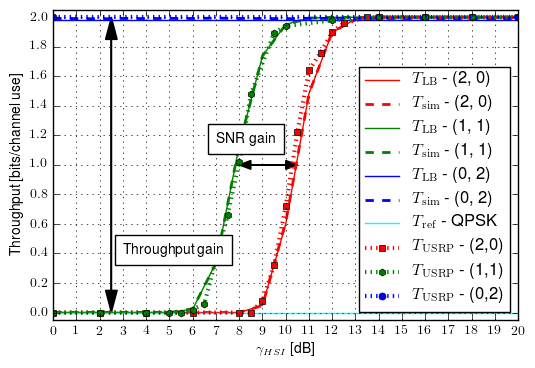

In [51]:

def double_arrowY(plt, x0, y0, x1, y1):
  hw = 0.5; hl = 0.15
  dx = x1 - x0; dy = y1 - y0
  plt.arrow(x0, y0, dx, dy - hl, head_width=hw, head_length=hl, fc='k', ec='k')
  plt.arrow(x1, y1, -dx, -dy + hl, head_width=hw, head_length=hl, fc='k', ec='k')

def double_arrowX(plt, x0, y0, x1, y1):
  hw = 0.06; hl = 0.5
  dx = x1 - x0; dy = y1 - y0
  plt.arrow(x0, y0, dx - hl, dy , head_width=hw, head_length=hl, fc='k', ec='k')
  plt.arrow(x1, y1, -dx + hl, -dy, head_width=hw, head_length=hl, fc='k', ec='k')

plt.figure(figsize=(6,4))
#line2_20_20 = line2
line_20_20 = eval_LB([20], [20]) #Analytical lower bound

line2_20_20 = np.array([np.array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.00000000e-04,
         4.70000000e-02,   6.12000000e-01,   1.48320000e+00,
         1.90160000e+00,   1.98300000e+00,   1.99940000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00]), np.array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0258,
        0.333 ,  1.1336,  1.7384,  1.9502,  1.9942,  1.9996,  1.9998,
        2.    ,  2.    ,  2.    ,  2.    ,  2.    ,  2.    ,  2.    ]), np.array([ 1.9912,  1.9912,  1.9892,  1.9922,  1.991 ,  1.9922,  1.9918,
        1.9944,  1.9918,  1.9918,  1.99  ,  1.9934,  1.9914,  1.9934,
        1.993 ,  1.9914,  1.9912,  1.9888,  1.9904,  1.9884,  1.9902])]
)


Nb1Ns1_real = np.array([[  0.   ,   0.   ],
       [  2.   ,   0.   ],
       [  4.   ,   0.   ],
       [  5.   ,   0.   ],
       [  5.5   ,   0.   ],
       [  6.   ,   0.02 ],
       [  6.5   ,   0.06 ],
       [  7.   ,   0.36 ],
       [  7.5   ,   0.66 ],
       [  8.   ,   1.02 ],
       [  8.5   ,   1.48 ],
#       [  9.   ,   1.82 ],
       [  9.5   ,   1.896],
       [ 10.   ,   1.94 ],
       [ 12.   ,   1.98 ],
       [ 14.   ,   2.   ],
       [ 16.   ,   2.   ],
       [ 18.   ,   2.   ],
       [ 20.   ,   2.   ]])

Nb2Ns0_real = np.array([[  0.  ,   0.  ],
       [  2.  ,   0.  ],
       [  4.  ,   0.  ],
       [  6.  ,   0.  ],
       [  8.  ,   0.  ],
       [  8.5  ,   0.  ],
       [  9.  ,   0.08],
       [  9.5  ,   0.32],
       [ 10.  ,   0.72],
       [ 10.5  ,   1.22],
       [ 11.  ,   1.64],
       [ 11.5  ,   1.76],
       [ 12.  ,   1.9 ],
       [ 12.5  ,   1.96],
#       [ 13.  ,   1.96],
       [ 13.5  ,   2.  ],
       [ 14.  ,   2.  ],
       [ 16.  ,   2.  ],
       [ 18.  ,   2.  ],
       [ 20.  ,   2.  ]])

Nb0Ns2_real = np.array([[  0.  ,   2.],
#       [ 10.  ,   2.  ],
       [ 20.  ,   2.  ]])


# Plotting
colors = ['red', 'green', 'blue']
for i in range(len(pairs)):
  (Ns,Nb) = pairs[i]
  plt.plot(SNR_HSI, 2*line_20_20[i],color=colors[i],linestyle='-',label='$T_{\mathrm{LB}}$ - ('+str(Nb)+', '+str(Ns)+')')
  plt.plot(SNR_HSI, line2_20_20[i],color=colors[i],linestyle='--',lw=2,label='$T_{\mathrm{sim}}$ - ('+str(Nb)+', '+str(Ns)+')')
plt.plot(SNR_HSI, np.zeros(len(SNR_HSI)), linestyle='-', color='cyan', label='$T_{\mathrm{ref}}$ - QPSK')
#plt.plot(Nb2Ns0_real[:,0],Nb2Ns0_real[:,1], color='red',linestyle=':',ms=5,lw=3, label='$T_{\mathrm{USRP}}$ - (2,0)')
#plt.plot(Nb1Ns1_real[:,0],Nb1Ns1_real[:,1], color='green',linestyle=':',ms=5,lw=3, label='$T_{\mathrm{USRP}}$ - (1,1)')
#plt.plot(Nb0Ns2_real[:,0],Nb0Ns2_real[:,1], color='blue',linestyle=':',ms=5,lw=3, label='$T_{\mathrm{USRP}}$ - (0,2)')
plt.plot(Nb2Ns0_real[:,0],Nb2Ns0_real[:,1], 'rs:',ms=5,lw=3, label='$T_{\mathrm{USRP}}$ - (2,0)')
plt.plot(Nb1Ns1_real[:,0],Nb1Ns1_real[:,1], 'gh:',ms=5,lw=3, label='$T_{\mathrm{USRP}}$ - (1,1)')
plt.plot(Nb0Ns2_real[:,0],Nb0Ns2_real[:,1], 'bo:',ms=5,lw=3, label='$T_{\mathrm{USRP}}$ - (0,2)')
plt.legend(loc=4,numpoints=1)

double_arrowY(plt, 2.5, 0, 2.5, 2)
#double_arrowY(plt, 11.5, 0, 11.5, 2)
double_arrowX(plt, 8, 1, 10.5, 1)
plt.text(3,0.4,'Throughput gain',  bbox=dict(facecolor='white', edgecolor='black', pad=6.0))
#plt.text(12,1.65,'Throughput gain',  bbox=dict(facecolor='white', edgecolor='black', pad=10.0))
plt.text(7,1.15,'SNR gain',  bbox=dict(facecolor='white', edgecolor='black', pad=6.0))

plt.xlabel('$\gamma_{HSI}$ [dB]')
plt.ylabel('Throughput [bits/channel use]')
plt.xticks(np.linspace(0,20,21))
plt.yticks(np.linspace(0,2,11))
plt.grid()
#plt.title('Throughput for '+mapping+' mapping and Fixed $\gamma_{MAC}$='+str(SNR_MAC[0])+'dB and $\gamma_{BC}$='+str(SNR_BC[0])+'dB',y=1.02)
plt.ylim([-0.05,2+0.05])
plt.savefig('Throughput_HSI_'+mapping+'_MAC'+str(20)+'_BC'+str(20)+'_N'+str(sum(pairs[0]))+'.eps',bbox_inches='tight')
plt.show()

#### Data Collected from the HW Demonstrator - SNR_MAC=20, SNR_BC=16

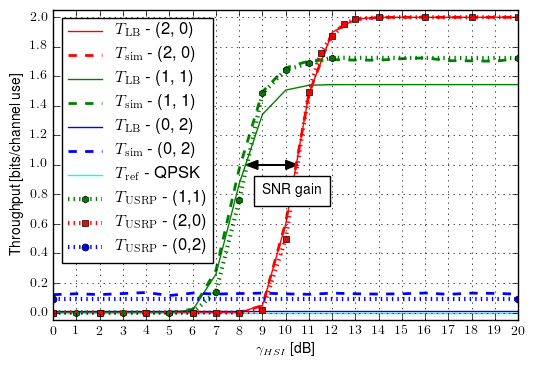

In [52]:
#line2_20_16 = line2
line_20_16= eval_LB([20], [16]) #Analytical lower bound

line2_20_16 = np.array([np.array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.00000000e-04,
         4.70000000e-02,   6.12000000e-01,   1.48320000e+00,
         1.90160000e+00,   1.98300000e+00,   1.99940000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00]), np.array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0222,
        0.287 ,  0.9748,  1.4952,  1.6578,  1.704 ,  1.7128,  1.7098,
        1.7094,  1.7194,  1.725 ,  1.7058,  1.7046,  1.7022,  1.7198]), np.array([ 0.121 ,  0.127 ,  0.1214,  0.1284,  0.1356,  0.115 ,  0.1316,
        0.1248,  0.1286,  0.1312,  0.1264,  0.1232,  0.1312,  0.127 ,
        0.1248,  0.127 ,  0.132 ,  0.1232,  0.1312,  0.1296,  0.1244])]
)


Nb1Ns1_real = np.array([[  0.   ,   0.   ],
       [  1.   ,   0.   ],
       [  2.   ,   0.   ],
       [  3.   ,   0.   ],
       [  4.   ,   0.   ],
       [  5.   ,   0.   ],
       [  6.   ,   0.   ],
       [  7.   ,   0.14 ],
       [  8.   ,   0.76 ],
       [  9.   ,   1.484],
       [ 10.   ,   1.644],
       [ 11.   ,   1.688],
       [ 12.   ,   1.7256],
       [ 20.   ,   1.724]])

Nb2Ns0_real = np.array([[  0.   ,   0.   ],
       [  2.   ,   0.   ],
       [  4.   ,   0.   ],
       [  6.   ,   0.   ],
       [  7.   ,   0.   ],
       [  8.   ,   0.   ],
       [  9.   ,   0.02 ],
       [ 10.   ,   0.5  ],
       [ 11.   ,   1.496],
       [ 11.5   ,   1.76 ],
       [ 12.   ,   1.872],
       [ 12.5   ,   1.952],
       [ 13.   ,   1.988],
       [ 14.   ,   2.   ],
       [ 16.   ,   2.   ],
       [ 18.   ,   2.   ],
       [ 20.   ,   2.   ]])

Nb0Ns2_real = np.array([[  0.  ,   0.0945454545455],
                        [20.,   0.0945454545455]])
#Nb0Ns2_real = np.array([[  0.  ,   0.06],
#       [  2.  ,   0.04],
#       [  4.  ,   0.02],
#       [  6.  ,   0.02],
#       [  8.  ,   0.  ],
#       [ 12.  ,   0.  ],
#       [ 14.  ,   0.  ],
#       [ 18.  ,   0.  ],
#       [ 20.  ,   0.06]])


plt.figure(figsize=(6,4))
colors = ['red', 'green', 'blue']
for i in range(len(pairs)):
  (Ns,Nb) = pairs[i]
  plt.plot(SNR_HSI, 2*line_20_16[i],color=colors[i],linestyle='-',label='$T_{\mathrm{LB}}$ - ('+str(Nb)+', '+str(Ns)+')')
  plt.plot(SNR_HSI, line2_20_16[i],color=colors[i],linestyle='--',lw=2,label='$T_{\mathrm{sim}}$ - ('+str(Nb)+', '+str(Ns)+')')
plt.plot(SNR_HSI, np.zeros(len(SNR_HSI)), linestyle='-', color='cyan', label='$T_{\mathrm{ref}}$ - QPSK')    
plt.plot(Nb1Ns1_real[:,0],Nb1Ns1_real[:,1], 'gh:',ms=5,lw=3, label='$T_{\mathrm{USRP}}$ - (1,1)')
plt.plot(Nb2Ns0_real[:,0],Nb2Ns0_real[:,1], 'rs:',ms=5,lw=3, label='$T_{\mathrm{USRP}}$ - (2,0)')
plt.plot(Nb0Ns2_real[:,0],Nb0Ns2_real[:,1], 'bo:',ms=5,lw=3, label='$T_{\mathrm{USRP}}$ - (0,2)')



#double_arrowY(plt, 14, 0, 14, 1.724)
double_arrowX(plt, 8.3, 1, 10.5, 1)

#plt.text(12,0.4,'Throughput gain',  bbox=dict(facecolor='white', edgecolor='black', pad=10.0))
plt.text(9,0.8,'SNR gain',  bbox=dict(facecolor='white', edgecolor='black', pad=6.0))

plt.legend(loc=2,numpoints=1)
plt.xlabel('$\gamma_{HSI}$ [dB]')
plt.ylabel('Throughput [bits/channel use]')
plt.xticks(np.linspace(0,20,21))
plt.yticks(np.linspace(0,2,11))
plt.grid()
#plt.title('Throughput for '+mapping+' mapping and Fixed $\gamma_{MAC}$='+str(SNR_MAC[0])+'dB and $\gamma_{BC}$='+str(SNR_BC[0])+'dB',y=1.02)
plt.ylim([-0.05,2+0.05])
plt.savefig('Throughput_HSI_'+mapping+'_MAC'+str(20)+'_BC'+str(16)+'_N'+str(sum(pairs[0]))+'.eps',bbox_inches='tight')
plt.show()

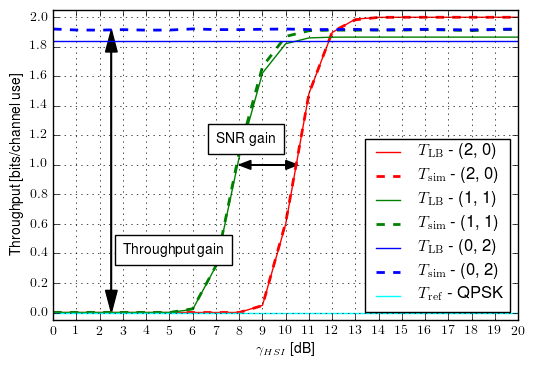

In [54]:
#line2_16_20 = line2

line_16_20= eval_LB([16], [20]) #Analytical lower bound
line2_16_20 = np.array([np.array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.00000000e-04,
         4.70000000e-02,   6.12000000e-01,   1.48320000e+00,
         1.90160000e+00,   1.98300000e+00,   1.99940000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00]), np.array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0254,
        0.3172,  1.0868,  1.6658,  1.8702,  1.909 ,  1.913 ,  1.9124,
        1.9138,  1.9128,  1.9168,  1.9136,  1.9096,  1.9172,  1.9174]), np.array([ 1.9204,  1.9136,  1.913 ,  1.9162,  1.9128,  1.9134,  1.921 ,
        1.9166,  1.9162,  1.9188,  1.9204,  1.9168,  1.917 ,  1.9178,
        1.9144,  1.9164,  1.9186,  1.916 ,  1.9146,  1.9176,  1.9208])]
)

# Plotting
plt.figure(figsize=(6,4))
colors = ['red', 'green', 'blue','magenta']
for i in range(len(pairs)):
  (Ns,Nb) = pairs[i]
  plt.plot(SNR_HSI, 2*line_16_20[i],color=colors[i],linestyle='-',label='$T_{\mathrm{LB}}$ - ('+str(Nb)+', '+str(Ns)+')')
  plt.plot(SNR_HSI, line2_16_20[i],color=colors[i],linestyle='--',lw=2,label='$T_{\mathrm{sim}}$ - ('+str(Nb)+', '+str(Ns)+')')
plt.plot(SNR_HSI, np.zeros(len(SNR_HSI)), linestyle='-', color='cyan', label='$T_{\mathrm{ref}}$ - QPSK')
plt.legend(loc=4)
plt.xlabel('$\gamma_{HSI}$ [dB]')
plt.ylabel('Throughput [bits/channel use]')
plt.xticks(np.linspace(0,20,21))
plt.yticks(np.linspace(0,2,11))
plt.grid()
double_arrowY(plt, 2.5, 0, 2.5, 1.915)
#double_arrowY(plt, 13.5, 0, 13.5, 1.915)
double_arrowX(plt, 8, 1, 10.5, 1)
plt.text(3,0.4,'Throughput gain',  bbox=dict(facecolor='white', edgecolor='black', pad=6.0))
#plt.text(14,1.65,'Throughput gain',  bbox=dict(facecolor='white', edgecolor='black', pad=10.0))
plt.text(7,1.15,'SNR gain',  bbox=dict(facecolor='white', edgecolor='black', pad=6.0))

#plt.title('Throughput for '+mapping+' mapping and Fixed $\gamma_{MAC}$='+str(SNR_MAC[0])+'dB and $\gamma_{BC}$='+str(SNR_BC[0])+'dB',y=1.02)
plt.ylim([-0.05,2+0.05])
plt.savefig('Throughput_HSI_'+mapping+'_MAC'+str(16)+'_BC'+str(20)+'_N'+str(sum(pairs[0]))+'.eps',bbox_inches='tight')
plt.show()

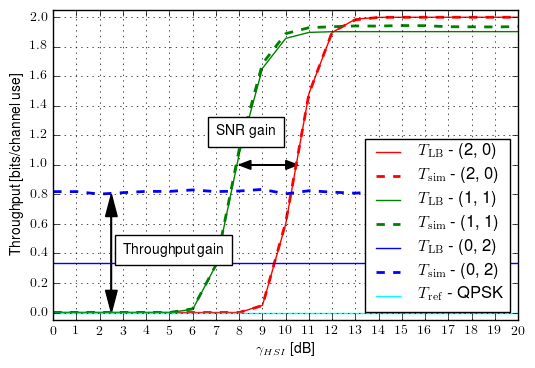

In [53]:
#line2_17_17 = line2
line_17_17= eval_LB([17], [17]) #Analytical lower bound
line2_17_17 = np.array([np.array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e-04,
          4.70000000e-02,   6.12000000e-01,   1.48320000e+00,
          1.90160000e+00,   1.98300000e+00,   1.99940000e+00,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00]),
 np.array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0252,
         0.3226,  1.1052,  1.6858,  1.8892,  1.9296,  1.936 ,  1.9412,
         1.9402,  1.944 ,  1.943 ,  1.936 ,  1.9352,  1.9344,  1.937 ]),
 np.array([ 0.8188,  0.819 ,  0.8022,  0.8118,  0.8204, 0.8204,  0.8304,
         0.819 ,  0.823 ,  0.8342,  0.8036,  0.825 ,  0.8152,  0.8084,
         0.8188,  0.8128,  0.83  ,  0.8146,  0.8362,  0.828 ,  0.822 ])])

# Plotting
plt.figure(figsize=(6,4))
colors = ['red', 'green', 'blue','magenta']
for i in range(len(pairs)):
  (Ns,Nb) = pairs[i]
  plt.plot(SNR_HSI, 2*line_17_17[i],color=colors[i],linestyle='-',label='$T_{\mathrm{LB}}$ - ('+str(Nb)+', '+str(Ns)+')')
  plt.plot(SNR_HSI, line2_17_17[i],color=colors[i],linestyle='--',lw=2,label='$T_{\mathrm{sim}}$ - ('+str(Nb)+', '+str(Ns)+')')
plt.plot(SNR_HSI, np.zeros(len(SNR_HSI)), linestyle='-', color='cyan', label='$T_{\mathrm{ref}}$ - QPSK')
plt.legend(loc=4)
plt.xlabel('$\gamma_{HSI}$ [dB]')
plt.ylabel('Throughput [bits/channel use]')
plt.xticks(np.linspace(0,20,21))
plt.yticks(np.linspace(0,2,11))
plt.grid()
double_arrowY(plt, 2.5, 0, 2.5, 0.8)
#double_arrowY(plt, 11.5, 0, 11.5, 1.92)
double_arrowX(plt, 8, 1, 10.5, 1)
plt.text(3,0.4,'Throughput gain',  bbox=dict(facecolor='white', edgecolor='black', pad=6.0))
#plt.text(12,1.65,'Throughput gain',  bbox=dict(facecolor='white', edgecolor='black', pad=10.0))
plt.text(7,1.2,'SNR gain',  bbox=dict(facecolor='white', edgecolor='black', pad=6.0))

#plt.title('Throughput for '+mapping+' mapping and Fixed $\gamma_{MAC}$='+str(SNR_MAC[0])+'dB and $\gamma_{BC}$='+str(SNR_BC[0])+'dB',y=1.02)
plt.ylim([-0.05,2+0.05])
plt.savefig('Throughput_HSI_'+mapping+'_MAC'+str(17)+'_BC'+str(17)+'_N'+str(sum(pairs[0]))+'.eps',bbox_inches='tight')
plt.show()

In [24]:
print line2
line2_16_20 = np.array([np.array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.00000000e-04,
         4.70000000e-02,   6.12000000e-01,   1.48320000e+00,
         1.90160000e+00,   1.98300000e+00,   1.99940000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00]), np.array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0254,
        0.3172,  1.0868,  1.6658,  1.8702,  1.909 ,  1.913 ,  1.9124,
        1.9138,  1.9128,  1.9168,  1.9136,  1.9096,  1.9172,  1.9174]), np.array([ 1.9204,  1.9136,  1.913 ,  1.9162,  1.9128,  1.9134,  1.921 ,
        1.9166,  1.9162,  1.9188,  1.9204,  1.9168,  1.917 ,  1.9178,
        1.9144,  1.9164,  1.9186,  1.916 ,  1.9146,  1.9176,  1.9208])]
)

[array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.00000000e-04,
         4.70000000e-02,   6.12000000e-01,   1.48320000e+00,
         1.90160000e+00,   1.98300000e+00,   1.99940000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00]), array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0254,
        0.3172,  1.0868,  1.6658,  1.8702,  1.909 ,  1.913 ,  1.9124,
        1.9138,  1.9128,  1.9168,  1.9136,  1.9096,  1.9172,  1.9174]), array([ 1.9204,  1.9136,  1.913 ,  1.9162,  1.9128,  1.9134,  1.921 ,
        1.9166,  1.9162,  1.9188,  1.9204,  1.9168,  1.917 ,  1.9178,
        1.9144,  1.9164,  1.9186,  1.916 ,  1.9146,  1.9176,  1.9208])]


In [7]:
basic_part

array([-0.66666667-0.66666667j, -0.66666667+0.66666667j,
        0.66666667-0.66666667j,  0.66666667+0.66666667j])

In [5]:
N = 8
tupples = np.asarray([(i,j) for i in range(0, N+1) for j in range(0, N-i+1) if i+2*j<=N])[1:]
for i in range(len(tupples)):
  Nb = tupples[i][0]
  Ns = tupples[i][1]
  (sourceA_const, sourceB_const, basic_part, relay_const, alpha) = const_design_XOR(Nb, Ns, h = 1)
  N = Nb + 2 * Ns
  constR, alpha_BC = QAM(N)
  (k_BC, rho2_BC) = eval_num_neigh(constR, alpha_BC) # BC min - dist
  (k_MAC, rho2_MAC) = eval_num_neigh(relay_const)
  if Nb > 0:
    (k_HSI, rho2_HSI) = eval_num_neigh(basic_part)
  else: 
    rho2_HSI=np.inf
  
  print Nb,Ns, rho2_MAC, rho2_HSI, rho2_BC

0 1 4.0 inf 2.0000000001
0 2 0.8 inf 0.4
0 3 0.1904761904 inf 0.0952380952
0 4 0.0470588235 inf 0.0235294117
1 0 4.0 4.0 4.0
1 1 0.8 3.2 0.6666666666
1 2 0.1904761904 3.0476190473 0.1538461538
1 3 0.0470588235 3.0117647061 0.037735849
2 0 2.0000000001 2.0000000001 2.0000000001
2 1 0.4444444444 1.777777778 0.4
2 2 0.1081081081 1.7297297296 0.0952380952
2 3 0.0268456376 1.7181208053 0.0235294117
3 0 0.3636363636 0.3636363636 0.6666666666
3 1 0.0888888889 0.3555555556 0.1538461538
3 2 0.0220994475 0.3535911602 0.037735849
4 0 0.2 0.2 0.4
4 1 0.049382716 0.1975308642 0.0952380952
4 2 0.0123076923 0.1969230769 0.0235294117
5 0 0.0396039604 0.0396039604 0.1538461538
5 1 0.0098765432 0.0395061728 0.037735849
6 0 0.021978022 0.021978022 0.0952380952
6 1 0.0054869684 0.0219478738 0.0235294117


KeyboardInterrupt: 

In [6]:
from scipy.optimize import linprog
from capacity_eval import *

Nb = 2
Ns = 1
M = 1e4
gMAC = 10
gHSI = 4.7
#gHSI = 5.5
gBC = 11.3


cBC = eval_cap_BC(Nb, Ns, gBC, M)
cHSI = eval_cap_HSI(Nb, Ns, gHSI, M)
#cMAC = eval_MAC_rand_phase(Nb, Ns, gMAC, M1 = 300, M2 = 300)

cMAC = eval_MAC(Nb, Ns, gMAC, M)
#cMAC = np.array( [3.16984004,  2.5764985 ,  2.57675782,  1.51168887,  0.75597148,  0.75571739,  1.98341627])
#cBC = 3.4487448266329639
#cHSI = 1.613597068410328
r3 = cMAC[0]
r2As = cMAC[1]
r2Bs = cMAC[2]
r2b = cMAC[3]
r1As = cMAC[4]
r1Bs = cMAC[5]
r1b = cMAC[6]

Rbs = np.array([r2As,r2Bs]).min()
Rbss = np.array([r3, cBC]).min()
Rs = np.array([r1As, r1Bs]).min()
Rb = np.array([r1b, cHSI]).min()
Rs2 = r2b/2




c = [-1, -1]
A = [[2, 1], [1, 1], [1,0], [0,1]]

b = [Rbss, Rbs, Rs, Rb]
x0_bounds = (0, None)
x1_bounds = (0, None)
res = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds))
plt.figure()
plt.plot([0,r3/2.],[r3, 0],'k--', lw=2, label='MAC - Third Order')
plt.plot([0,r2As],[r2As, 0],'k-.', lw=2, label='MAC - Second Order')
plt.plot([Rs, Rs],[0, r1b],'k-', lw=2, label='MAC - First Order')
#plt.plot([Rs2, Rs2],[0, r1b],'r--', lw=2, label='MAC - First Order 2')
plt.plot([0,Rs],[r1b, r1b],'k-', lw=2)
plt.plot([0,Rs],[cHSI,cHSI],'r-', lw=2, label='HSI')
plt.plot([0,cBC/2.],[cBC, 0],'m--', lw=2, label='BC - $2^{N_R}$-QAM')


plt.plot([res.items()[4][1][0]],[res.items()[4][1][1]],'mo', ms=15, label='Maximum $r_b+r_s$')
#plt.plot([0.66],[1.5],'mx', ms=15,lw=5, label='Achived performance - LDPC')
#plt.plot([0.71],[1.5],'b+', ms=15,lw=5, label='Achived performance - Turbo')

plt.legend(numpoints=1)
plt.xlabel('$r_s$')
plt.ylabel('$r_b$') 
plt.title('Rate region for ($N_b,N_s$)=('+str(Nb)+','+str(Ns)+'), $\gamma_{MAC=}$'+str(gMAC)+'dB, $\gamma_{HSI=}$'+str(gHSI)+'dB, $\gamma_{BC}$='+str(gBC)+'dB')
plt.savefig('Rate_Regions_XOR_map_BC'+str(gBC)+'_MAC'+str(gMAC)+'_HSI'+str(gHSI)+'.eps')
plt.show()

ImportError: No module named capacity_eval

In [130]:
from scipy.optimize import linprog
from capacity_eval import *

Nb = 2
Ns = 1
M = 1e4
gMAC = 7.5
gHSI = 10
#gHSI = 5.5
gBC = 10


cBC = eval_cap_BC(Nb, Ns, gBC, M)
cHSI = eval_cap_HSI(Nb, Ns, gHSI, M)
#cMAC = eval_MAC_rand_phase(Nb, Ns, gMAC, M1 = 300, M2 = 300)

cMAC = eval_MAC(Nb, Ns, gMAC, M)
#cMAC = np.array( [3.16984004,  2.5764985 ,  2.57675782,  1.51168887,  0.75597148,  0.75571739,  1.98341627])
#cBC = 3.4487448266329639
#cHSI = 1.613597068410328
r3 = cMAC[0]
r2As = cMAC[1]
r2Bs = cMAC[2]
r2b = cMAC[3]
r1As = cMAC[4]
r1Bs = cMAC[5]
r1b = cMAC[6]

Rbs = np.array([r2As,r2Bs]).min()
Rbss = np.array([r3, cBC]).min()
Rs = np.array([r1As, r1Bs]).min()
Rb = np.array([r1b, cHSI]).min()
Rs2 = r2b/2




c = [-1, -1]
A = [[2, 1], [1, 1], [1,0], [0,1]]

b = [Rbss, Rbs, Rs, Rb]
x0_bounds = (0, None)
x1_bounds = (0, None)
resX = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds))
plt.figure()
plt.plot([0,r3/2.],[r3, 0],'k--', lw=2, label='MAC - Third Order')
plt.plot([0,r2As],[r2As, 0],'k-.', lw=2, label='MAC - Second Order')
plt.plot([Rs, Rs],[0, np.array([r3, cBC]).max()],'k:', lw=2, label='MAC - First Order')
plt.plot([0,Rbss],[r1b,r1b],'k:', lw=2)
plt.plot([0,Rbss],[cHSI,cHSI],'r-', lw=2, label='HSI')
plt.plot([0,cBC/2.],[cBC, 0],'m--', lw=2, label='BC - (conv. $2^{N_R}$-QAM)')


plt.plot([resX.items()[4][1][0]],[resX.items()[4][1][1]],'mo', ms=15, label='Maximum $r_b+r_s$')
#plt.plot([0.66],[1.5],'mx', ms=15,lw=5, label='Achived performance - LDPC')
#plt.plot([0.71],[1.5],'b+', ms=15,lw=5, label='Achived performance - Turbo')

plt.legend(numpoints=1)
plt.xlabel('$r_s$')
plt.ylabel('$r_b$') 
#plt.title('Rate region for ($N_b,N_s$)=('+str(Nb)+','+str(Ns)+'), $\gamma_{MAC=}$'+str(gMAC)+'dB, $\gamma_{HSI=}$'+str(gHSI)+'dB, $\gamma_{BC}$='+str(gBC)+'dB')
plt.savefig('Rate_Regions_XOR_map_BC'+str(gBC)+'_MAC'+str(gMAC)+'_HSI'+str(gHSI)+'.eps')
plt.show()

#### CUT-SET Bound rate adjustments

In [75]:
from scipy.optimize import linprog
from capacity_eval import *

Nb = 2
Ns = 1
M = 1e4
gMAC = 10
gHSI = 4.7
#gHSI = 5.5
gBC = 11.3

Nb = 2
Ns = 1
M = 1e4
gMAC = 5
gHSI = 0
#gHSI = 5.5
gBC = 5

cBC = eval_cap_BC(Nb, Ns, gBC, M)
cHSI = eval_cap_HSI(Nb, Ns, gHSI, M)
#cMAC = eval_MAC_rand_phase(Nb, Ns, gMAC, M1 = 300, M2 = 300)

cMAC = eval_MAC(Nb, Ns, gMAC, M)
#cMAC = np.array( [3.16984004,  2.5764985 ,  2.57675782,  1.51168887,  0.75597148,  0.75571739,  1.98341627])
#cBC = 3.4487448266329639
#cHSI = 1.613597068410328
r3 = cMAC[0]
r2As = cMAC[1]
r2Bs = cMAC[2]
r2b = cMAC[3]
r1As = cMAC[4]
r1Bs = cMAC[5]
r1b = cMAC[6]

Rbs = np.array([r2As,r2Bs]).min()
Rbss = np.array([r3, cBC]).min()
Rs = np.array([r1As, r1Bs]).min()
Rb = np.array([r1b, cHSI]).min()
Rs2 = r2b/2

xmax = Rbss
ymax = Rbss

p1 = np.max([0,(Rbss-Rb)/2.])
p2 = np.max([0,Rbss-2*Rs])

c = [-1, -1]
A = [[2, 1], [1, 1], [1,0], [0,1]]

b = [Rbss, Rbs, Rs, Rb]
x0_bounds = (0, None)
x1_bounds = (0, None)
resX = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds))
ax = plt.figure(figsize=(10,10))

#plt.fill([0,0,p1,np.min([Rbss/2,Rs]),np.min([Rbss/2,Rs])],[0,np.min([Rb, Rbss]),np.min([Rb, Rbss]),p2,0], fill='True', color='#ddddff')
plt.fill([0,np.min([Rbss/2,Rs]),np.min([Rbss/2,Rs]),0],[0,0,np.min([Rb, Rbss]),np.min([Rb, Rbss])], fill='True', color='#ddddff')
plt.plot([0,r3/2.],[r3, 0],'k--', lw=2, label='MAC - Third Order')
plt.plot([0,r2As],[r2As, 0],'k-.', lw=2, label='MAC - Second Order')
plt.plot([Rs, Rs],[0, ymax],'k:', lw=2, label='MAC - First Order')
#plt.plot([Rs2, Rs2],[0, r1b],'r--', lw=2, label='MAC - First Order 2')
plt.plot([0,xmax],[cHSI,cHSI],'r-', lw=2, label='HSI')
plt.plot([0,xmax],[r1b, r1b],'k:', lw=2)
plt.plot([0,cBC/2.],[cBC, 0],'m-', lw=2, label='BC - $2^{N_R}$-QAM')
#plt.add_patch(Polygon([[0,0],[4,1.1],[6,2.5],[2,1.4]], closed=True, fill=False, hatch='/'))


plt.plot([resX.items()[4][1][0]],[resX.items()[4][1][1]],'kx',mew=5, ms=15, label='Maximum $r_b+r_s$')
#plt.plot([0.66],[1.5],'mo', ms=15,lw=5, label='Achieved performance - LDPC')
plt.plot([0.34],[0.84],'mo', ms=15,lw=5, label='Achieved $r_b+r_s$') #  5  0  5
#plt.plot([0.58],[1.8],'mo', ms=15,lw=5, label='Achieved $r_b+r_s$')  # 12  8 10 
#plt.plot([0.71],[1.5],'b+', ms=15,lw=5, label='Achived performance - Turbo')

plt.legend(numpoints=1)
plt.xlabel('$r_s$', fontsize=18)
plt.ylabel('$r_b$', fontsize=18)
plt.xlim([0,xmax])
plt.ylim([0,ymax])
plt.title('$\gamma_{MAC=}$'+str(gMAC)+'dB, $\gamma_{HSI=}$'+str(gHSI)+'dB, $\gamma_{BC}$='+str(gBC)+'dB', fontsize=16)
plt.savefig('Rate_Regions_XOR_map_BC'+str(gBC)+'_MAC'+str(gMAC)+'_HSI'+str(gHSI)+'.eps', bbox_inches='tight')
#plt.savefig('Rate_Regions_XOR_map_BC'+str(gBC)+'_MAC'+str(gMAC)+'_HSI'+str(gHSI)+'.eps')
plt.show()

In [175]:
#import six
#plt.fill([0,0,np.min([Rbss/2, Rs]),0],[0,np.min([Rb, Rbss]),0,0], fill='True', color='#eeeeff', hatch='\\')
#plt.fill([0,0,Rs,np.min([Rbss/2,Rs])],[0,np.min([Rb, Rbss]),p2,0], fill='True', color='#ddddff')
plt.fill([0,np.min([Rbss/2,Rs]),np.min([Rbss/2,Rs]),0],[0,0,np.min([Rb, Rbss]),np.min([Rb, Rbss])], fill='True', color='#ddddff')
plt.show() 
print resX

  status: 0
   slack: array([ 0.16454502,  0.38957251,  0.        ,  0.        ])
 success: True
     fun: -1.2731988159720324
       x: array([ 0.37250992,  0.90068889])
 message: 'Optimization terminated successfully.'
     nit: 2


#### Drawing Coded adaptive MAC regions

In [6]:
run capacity_eval

In [7]:
SNR_MAC = np.linspace(-5,20,26)
SNR_BC = np.array([7.5,15])
SNR_HSI = np.linspace(-5,20,26)
N = 4

tuples = np.asarray([(i,j) for i in range(0, N+1) for j in range(0, N-i+1) if i+2*j<=N])[1:]
ll = len(tuples)
cap_BC = []
cap_HSI = []
cap_MAC = []
for i in range(5):
  (Nb, Ns) = tuples[i]
  print 'evaluating capacity for the pair', (Nb, Ns)
  cap_BC.append(Parallel(n_jobs=8)(delayed(eval_cap_BC)(Nb, Ns, SNR, M=1e4) for  SNR in SNR_BC))
  print 'BC completed'
  cap_HSI.append(Parallel(n_jobs=8)(delayed(eval_cap_HSI)(Nb, Ns, SNR, M=1e4) for  SNR in SNR_HSI))
  print 'HSI completed'
  cap_MAC.append(Parallel(n_jobs=8)(delayed(eval_MAC_ef)(Nb, Ns, SNR, M=1e4) for  SNR in SNR_MAC))
  print 'MAC completed'

for i in range(5,ll):
  (Nb, Ns) = tuples[i]
  print 'evaluating capacity for the pair', (Nb, Ns)
  cap_BC.append(Parallel(n_jobs=8)(delayed(eval_cap_BC)(Nb, Ns, SNR, M=1e4) for  SNR in SNR_BC))
  print 'BC completed'
  cap_HSI.append(Parallel(n_jobs=8)(delayed(eval_cap_HSI)(Nb, Ns, SNR, M=1e4) for  SNR in SNR_HSI))
  print 'HSI completed'
  cap_MAC.append(Parallel(n_jobs=8)(delayed(eval_MAC_ef)(Nb, Ns, SNR, M=1e3) for  SNR in SNR_MAC))
  print 'MAC completed'

evaluating capacity for the pair (0, 1)
BC completed
HSI completed
MAC completed
evaluating capacity for the pair (0, 2)
BC completed
HSI completed
MAC completed
evaluating capacity for the pair (1, 0)
BC completed
HSI completed
MAC completed
evaluating capacity for the pair (1, 1)
BC completed
HSI completed
MAC completed
evaluating capacity for the pair (2, 0)
BC completed
HSI completed
MAC completed
evaluating capacity for the pair (2, 1)
BC completed
HSI completed
MAC completed
evaluating capacity for the pair (3, 0)
BC completed
HSI completed
MAC completed
evaluating capacity for the pair (4, 0)
BC completed
HSI completed
MAC completed


In [8]:
N = len(tuples)
res = (Parallel(n_jobs=8)(delayed(cap_inner_rb_rs)\
                          (i, np.asarray(cap_MAC), np.asarray(cap_BC), np.asarray(cap_HSI), N, SNR_MAC, SNR_BC, SNR_HSI)\
                          for i in range(len(SNR_MAC))))

In [9]:
ress = np.asarray(res)
print np.shape(np.asarray(ress))

adapt = np.max(ress[:,:,:,:,0]+ress[:,:,:,:,1],axis=3)
args = np.argmax(ress[:,:,:,:,0]+ress[:,:,:,:,1],axis=3)
print np.shape(adapt), np.shape(args)

adapt_rB = np.asarray([ress[i, j, k, args[i,j,k],1] for i in range(26) for j in range(2) for k in range(26)]).reshape(26,2,26)
adapt_rS = np.asarray([ress[i, j, k, args[i,j,k],0] for i in range(26) for j in range(2) for k in range(26)]).reshape(26,2,26)

print adapt_rB.shape

(26, 2, 26, 8, 2)
(26, 2, 26) (26, 2, 26)
(26, 2, 26)


In [13]:
plt.figure()
ind = 0
rb1 = adapt_rB[:,ind,:].transpose()
rs1 = adapt_rS[:,ind,:].transpose()
act = adapt[:,ind,:].transpose()#adapt_rB[:,0,:] + adapt_rS[:,1,:]

plt.imshow(rb1[-1::-1,:],\
extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)],vmin=0, vmax=4) # xmin, xmax, ymin, ymax
plt.colorbar()
plt.xlabel('$\gamma_{MAC}$ [dB]',fontsize=16)
plt.ylabel('$\gamma_{HSI}$ [dB]',fontsize=16)
plt.title('Basic Part, $\gamma_{BC}='+str(SNR_BC[ind])+'dB$',fontsize=16)
levels(plt,SNR_MAC, SNR_HSI, tuples, args[:,ind,:].transpose())
plt.savefig('Adaptive_Maps_basic_BC_'+str(SNR_BC[ind])+'.eps',bbox_inches='tight')

plt.figure()
plt.imshow(rs1[-1::-1,:],\
extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)],vmin=0, vmax=4) # xmin, xmax, ymin, ymax
plt.colorbar()
plt.xlabel('$\gamma_{MAC}$ [dB]',fontsize=16)
plt.ylabel('$\gamma_{HSI}$ [dB]',fontsize=16)
plt.title('Superposed Part, $\gamma_{BC}='+str(SNR_BC[ind])+'dB$',fontsize=16)
levels(plt,SNR_MAC, SNR_HSI, tuples,args[:,ind,:].transpose())
plt.savefig('Adaptive_Maps_superposed_BC_'+str(SNR_BC[ind])+'.eps',bbox_inches='tight')

plt.figure()
plt.imshow(act[-1::-1,:],\
extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)],vmin=0, vmax=4) # xmin, xmax, ymin, ymax
plt.colorbar()
plt.xlabel('$\gamma_{MAC}$ [dB]',fontsize=16)
plt.ylabel('$\gamma_{HSI}$ [dB]',fontsize=16)
plt.title('$\gamma_{BC}='+str(SNR_BC[ind])+'dB$',fontsize=16)
levels(plt,SNR_MAC, SNR_HSI, tuples, args[:,ind,:].transpose())
plt.savefig('Adaptive_Maps_overall_BC_'+str(SNR_BC[ind])+'.eps',bbox_inches='tight')

plt.show()

/usr/lib64/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib64/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [8]:
aa = [adapt[:,0,:].transpose(), adapt[:,1,:].transpose()]

In [12]:
def levels(plt,SNR_MAC, SNR_HSI, tuples, args):
#  levs = [0,1,2,3,4,5,6]    
  levs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]    
  CS = plt.contour(args,len(levs),\
                levels=levs, colors='k',\
                extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
  zc = CS.collections
  plt.setp(zc, linewidth=2)
  for i in range(len(tuples)):
    if len(np.nonzero(args == i)[0] > 0):        
      x = np.nonzero(args== i)[1][0]
      y = np.nonzero(args == i)[0][0]
      Nb = tuples[i, 0]
      Ns = tuples[i, 1]
#    print Nb,Ns
      s = "".join(('(',str(Nb),',',str(Ns),')'))
      line = np.arange(np.min(SNR_MAC), np.max(SNR_MAC),(SNR_MAC[-1]-SNR_MAC[0])/len(SNR_MAC))
    #plt.text(line[x],line[y],s,backgroundcolor='white')
#      plt.text(SNR_MAC[x],SNR_HSI[y],s,backgroundcolor='white')
  plt.text(2,10,'(2,0)',backgroundcolor='white')
  plt.text(-3,-3,'(0,2)',backgroundcolor='white')
  plt.text(10,-3,'(1,1)',backgroundcolor='white')
  plt.text(12,3,'(2,1)',backgroundcolor='white')
  plt.text(15,15,'(4,0)',backgroundcolor='white')
  #plt.text(2,10,'(2,0)',backgroundcolor='white')


In [37]:
ind = 0 # SNR_BC = 7.5

def levels(plt,SNR_MAC, SNR_HSI, tuples, args):
#  levs = [0,1,2,3,4,5,6]
  levs = [0,2,4,6]
#  levs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]    
  CS = plt.contour(args,len(levs),\
                levels=levs, colors='k',\
                extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)])
  zc = CS.collections
  plt.setp(zc, linewidth=6)
  for i in range(len(tuples)):
    if len(np.nonzero(args == i)[0] > 0):        
      x = np.nonzero(args== i)[1][0]
      y = np.nonzero(args == i)[0][0]
      Nb = tuples[i, 0]
      Ns = tuples[i, 1]
#    print Nb,Ns
      s = "".join(('(',str(Nb),',',str(Ns),')'))
      line = np.arange(np.min(SNR_MAC), np.max(SNR_MAC),(SNR_MAC[-1]-SNR_MAC[0])/len(SNR_MAC))
    #plt.text(line[x],line[y],s,backgroundcolor='white')
#      plt.text(SNR_MAC[x],SNR_HSI[y],s,backgroundcolor='white')
  plt.text(2,10,'(2,0)',backgroundcolor='white')
  plt.text(-3,-3,'(0,2)',backgroundcolor='white')
  plt.text(10,-3,'(1,1)',backgroundcolor='white')
  plt.text(12,3,'(2,1)',backgroundcolor='white')
  plt.text(15,15,'(4,0)',backgroundcolor='white')
  #plt.text(2,10,'(2,0)',backgroundcolor='white')

plt.figure()
plt.imshow(act[-1::-1,:],\
extent=[np.min(SNR_MAC), np.max(SNR_MAC), np.min(SNR_HSI),np.max(SNR_HSI)],vmin=0, vmax=4) # xmin, xmax, ymin, ymax
plt.colorbar()
plt.xlabel('$\gamma_{MAC}$ [dB]',fontsize=16)
plt.ylabel('$\gamma_{HSI}$ [dB]',fontsize=16)
plt.title('$\gamma_{BC}='+str(SNR_BC[ind])+'dB$',fontsize=16)
levels(plt,SNR_MAC, SNR_HSI, tuples, args[:,ind,:].transpose())
plt.savefig('Adaptive_Maps_overall_BC_'+str(SNR_BC[ind])+'.eps',bbox_inches='tight')

plt.show()

In [35]:
plt.imshow(args[-1::-1,0,:])
plt.show()

In [30]:
np.unique(args)
#args[249,0,100]

array([1, 3, 4, 5, 7])

In [82]:
[ress[200,0,200,7,0],ress[249,0,200,7,1]]

[0.0, 1.9687658422846086]

In [83]:
[ress[200,0,200,5,0],ress[200,0,200,5,1]]

[0.0, 1.9687658422846086]

In [77]:
0.1487176832749707+1.6713304757346672

1.8200481590096378

In [78]:
np.argmax(ress[:,:,:,:,0]+ress[:,:,:,:,1],axis=3)[249,0,100]

7

In [96]:
#  f = open('ress.dat','w')
#  pickle.dump(ress, f)
#  f.close()

In [56]:
np.shape(ress)

(31, 31, 31, 15, 2)

In [58]:
SNR_MAC = np.linspace(-5,20,250)
SNR_BC = np.array([7.5,15])
SNR_HSI = np.linspace(-5,20,250)

In [41]:
np.asarray(cap_MAC).shape

(8, 250, 7)

In [ ]:
cap_HSI

In [4]:
data = open('table.dat', 'rb')
strategy, tupples, SNR_HSI, SNR_MAC, SNR_BC = pickle.load(data)
data.close()

In [5]:
strategy.shape

(30, 30, 30)

In [31]:
plt.imshow(strategy[-1::-1,:,21])
plt.colorbar()

plt.figure()
plt.imshow(max_trough[-1::-1,:,21])
plt.colorbar()
plt.show()

In [27]:
np.asarray(through).shape

(8, 30, 30, 30)

In [30]:
  tupples = np.asarray([(i,j) for i in range(0, N+1) for j in range(0, N-i+1) if i+2*j<=N])[1:] # all feassible Nb,Ns tupples
  through = []
  for [Nb, Ns] in tupples:
      through.append(2*Throughput_Eval_range_all(Nb, Ns, SNR_MAC, SNR_HSI, SNR_BC, 'XOR',768, h=1., D='single'))
  strategy = np.zeros([len(SNR_BC), len(SNR_HSI), len(SNR_MAC)],int)
  for i in range(len(through)):
    act_range = np.hstack([np.arange(0, i), np.arange(i+1, len(through))])  
    x,y,z = np.nonzero(through[i]>=(np.max(np.asarray(through)[act_range,:,:,:], axis=0)))
    for j in range(len(x)):
      strategy[x[j], y[j],z[j]] = i 
  max_trough = np.max(np.asarray(through), axis = 0)
 

In [63]:
import pickle

SNR_MAC = np.linspace(0,30,31)
SNR_BC = np.linspace(0,30,31)
SNR_HSI = np.linspace(0,30,31)
N = 6
tuples = np.asarray([(i,j) for i in range(0, N+1) for j in range(0, N-i+1) if i+2*j<=N])[1:]
adaptive_map = pickle.load(open('adaptive_coded_maps.dat','r'))

#ress = np.asarray(res)
print np.shape(np.asarray(adaptive_map))

adapt = np.max(adaptive_map[:,:,:,:,0]+adaptive_map[:,:,:,:,1],axis=3)
args = np.argmax(adaptive_map[:,:,:,:,0]+adaptive_map[:,:,:,:,1],axis=3)
print np.shape(adapt), np.shape(args)

adapt_rB = np.asarray([ress[i, j, k, args[i,j,k],1] for i in range(31) for j in range(31) for k in range(31)]).reshape(31,31,31)
adapt_rS = np.asarray([ress[i, j, k, args[i,j,k],0] for i in range(31) for j in range(31) for k in range(31)]).reshape(31,31,31)

print adapt_rB.shape

test = np.asarray([np.sum(adaptive_map[i,i,i,:-3,:],axis=1) for i in range(31)])
plt.plot(test)
plt.show()

(31, 31, 31, 15, 2)
(31, 31, 31) (31, 31, 31)
(31, 31, 31)


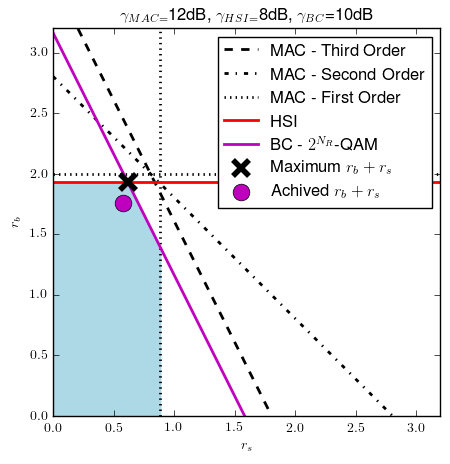

In [8]:
from scipy.optimize import linprog
from capacity_eval import *

Nb = 2
Ns = 1
M = 1e4
gMAC = 12
gHSI = 8
#gHSI = 5.5
gBC = 10


cBC = eval_cap_BC(Nb, Ns, gBC, M)
cHSI = eval_cap_HSI(Nb, Ns, gHSI, M)
#cMAC = eval_MAC_rand_phase(Nb, Ns, gMAC, M1 = 300, M2 = 300)

cMAC = eval_MAC(Nb, Ns, gMAC, M)
#cMAC = np.array( [3.16984004,  2.5764985 ,  2.57675782,  1.51168887,  0.75597148,  0.75571739,  1.98341627])
#cBC = 3.4487448266329639
#cHSI = 1.613597068410328
r3 = cMAC[0]
r2As = cMAC[1]
r2Bs = cMAC[2]
r2b = cMAC[3]
r1As = cMAC[4]
r1Bs = cMAC[5]
r1b = cMAC[6]

Rbs = np.array([r2As,r2Bs]).min()
Rbss = np.array([r3, cBC]).min()
Rs = np.array([r1As, r1Bs]).min()
Rb = np.array([r1b, cHSI]).min()
Rs2 = r2b/2




c = [-1, -1]
A = [[2, 1], [1, 1], [1,0], [0,1]]

b = [Rbss, Rbs, Rs, Rb]
x0_bounds = (0, None)
x1_bounds = (0, None)
res = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds))
plt.figure(figsize=(5,5))
plt.plot([0,r3/2.],[r3, 0],'k--', lw=2, label='MAC - Third Order')
plt.plot([0,r2As],[r2As, 0],'k-.', lw=2, label='MAC - Second Order')
plt.plot([Rs, Rs],[0, 3.2],'k:', lw=2, label='MAC - First Order')
#plt.plot([Rs2, Rs2],[0, r1b],'r--', lw=2, label='MAC - First Order 2')
plt.plot([0,3.2],[r1b, r1b],'k:', lw=2)
plt.plot([0,3.2],[cHSI,cHSI],'r-', lw=2, label='HSI')
plt.plot([0,cBC/2.],[cBC, 0],'m-', lw=2, label='BC - $2^{N_R}$-QAM')

plt.fill_between([0, res.items()[4][1][0], Rs], [cHSI, res.items()[4][1][1], cBC-2*Rs], [0,0,0], color='lightblue')
plt.plot([res.items()[4][1][0]],[res.items()[4][1][1]],'kx', ms=12, mew=4, label='Maximum $r_b+r_s$')
#plt.plot([0.66],[1.5],'mx', ms=15,lw=5, label='Achived performance - LDPC')
plt.plot([0.58],[1.76],'mo', fillstyle='full', ms=12,lw=5, label='Achived $r_b+r_s$')

plt.xlim([0,3.2])
plt.ylim([0,3.2])
plt.legend(numpoints=1)
plt.xlabel('$r_s$')
plt.ylabel('$r_b$') 
plt.title('$\gamma_{MAC=}$'+str(gMAC)+'dB, $\gamma_{HSI=}$'+str(gHSI)+'dB, $\gamma_{BC}$='+str(gBC)+'dB')
plt.savefig('Rate_Regions_XOR_map_BC'+str(gBC)+'_MAC'+str(gMAC)+'_HSI'+str(gHSI)+'.eps')
plt.show()

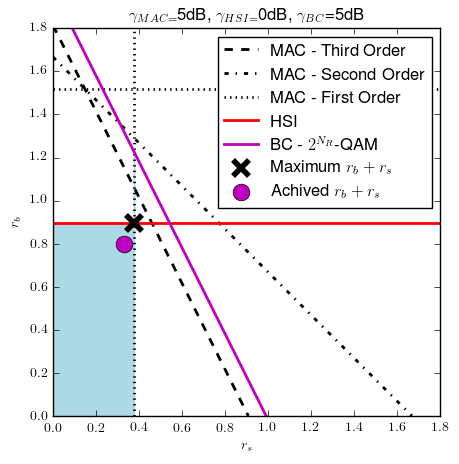

In [9]:
Nb = 2
Ns = 1
M = 1e4
gMAC = 5
gHSI = 0
#gHSI = 5.5
gBC = 5


cBC = eval_cap_BC(Nb, Ns, gBC, M)
cHSI = eval_cap_HSI(Nb, Ns, gHSI, M)
#cMAC = eval_MAC_rand_phase(Nb, Ns, gMAC, M1 = 300, M2 = 300)

cMAC = eval_MAC(Nb, Ns, gMAC, M)
#cMAC = np.array( [3.16984004,  2.5764985 ,  2.57675782,  1.51168887,  0.75597148,  0.75571739,  1.98341627])
#cBC = 3.4487448266329639
#cHSI = 1.613597068410328
r3 = cMAC[0]
r2As = cMAC[1]
r2Bs = cMAC[2]
r2b = cMAC[3]
r1As = cMAC[4]
r1Bs = cMAC[5]
r1b = cMAC[6]

Rbs = np.array([r2As,r2Bs]).min()
Rbss = np.array([r3, cBC]).min()
Rs = np.array([r1As, r1Bs]).min()
Rb = np.array([r1b, cHSI]).min()
Rs2 = r2b/2




c = [-1, -1]
A = [[2, 1], [1, 1], [1,0], [0,1]]

b = [Rbss, Rbs, Rs, Rb]
x0_bounds = (0, None)
x1_bounds = (0, None)
res = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds))
plt.figure(figsize=(5,5))
plt.plot([0,r3/2.],[r3, 0],'k--', lw=2, label='MAC - Third Order')
plt.plot([0,r2As],[r2As, 0],'k-.', lw=2, label='MAC - Second Order')
plt.plot([Rs, Rs],[0, 1.8],'k:', lw=2, label='MAC - First Order')
#plt.plot([Rs2, Rs2],[0, r1b],'r--', lw=2, label='MAC - First Order 2')
plt.plot([0,1.8],[r1b, r1b],'k:', lw=2)
plt.plot([0,1.8],[cHSI,cHSI],'r-', lw=2, label='HSI')
plt.plot([0,cBC/2.],[cBC, 0],'m-', lw=2, label='BC - $2^{N_R}$-QAM')

plt.fill_between([0, res.items()[4][1][0], Rs], [cHSI, res.items()[4][1][1], cBC-2*Rs], [0,0,0], color='lightblue')
plt.plot([res.items()[4][1][0]],[res.items()[4][1][1]],'kx', ms=12, mew=4, label='Maximum $r_b+r_s$')
#plt.plot([0.66],[1.5],'mx', ms=15,lw=5, label='Achived performance - LDPC')
plt.plot([0.33],[0.8],'mo', fillstyle='full', ms=12,lw=5, label='Achived $r_b+r_s$')

plt.xlim([0,1.8])
plt.ylim([0,1.8])
plt.legend(numpoints=1)
plt.xlabel('$r_s$')
plt.ylabel('$r_b$') 
plt.title('$\gamma_{MAC=}$'+str(gMAC)+'dB, $\gamma_{HSI=}$'+str(gHSI)+'dB, $\gamma_{BC}$='+str(gBC)+'dB')
plt.savefig('Rate_Regions_XOR_map_BC'+str(gBC)+'_MAC'+str(gMAC)+'_HSI'+str(gHSI)+'.eps')
plt.show()